# Machine Learning & Statistics Project

# Introduction

We have been tasked with creating a web service that uses machine learning to make predictions based on the data set provided on power production taken from Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. We must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. 

Keras could be used to manage the data. Takes large number of float inputs and provides output

# Introduction

# Wind Power Description



In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import the csv file containing the information
df = pd.read_csv('powerproduction.txt')

# Check first 10 rows to ensure we're getting correct data in as first 5 columns power outputt displayed as 0
print(f'{df.head(11)}\n')
print(f'{df.tail(15)}\n')

# Display dataframes information
print(f'{df.info()}\n')
print(f'{df.describe()}\n')

print(f'{df.isnull().sum()}\n')
print(f'{df.isna().sum()}')

    speed  power
0   0.000  0.000
1   0.125  0.000
2   0.150  0.000
3   0.225  0.000
4   0.275  0.000
5   0.325  4.331
6   0.400  5.186
7   0.450  3.826
8   0.501  1.048
9   0.526  5.553
10  0.551  6.498

      speed    power
485  24.249  103.700
486  24.299   93.694
487  24.349   93.078
488  24.374   98.223
489  24.399   95.117
490  24.499    0.000
491  24.525    0.000
492  24.575    0.000
493  24.650    0.000
494  24.750    0.000
495  24.775    0.000
496  24.850    0.000
497  24.875    0.000
498  24.950    0.000
499  25.000    0.000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
None

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6

From the above we can see that the information received is 2 colmuns of 500 rows populated by floats. We can also see that at the minimum and maximum speed values there is a value of 0 which may throw off the results of our calculation as this is most likely a cut off switch. There appears to be no missing information in the data as shown by our df.isnull().sum() and df.isna().sum() check. This data will need to be cleaned before it will be useable. Too determine if there are any other  anomolies we'll plot some graphs to give a better visual representation off the data.

In [82]:
df= df[df['power'] != 0]

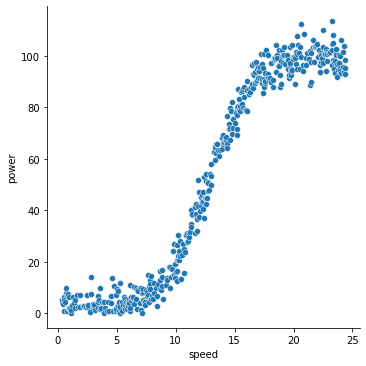

In [83]:
# Visualise dataset
sns.relplot(data=df, x="speed", y="power")

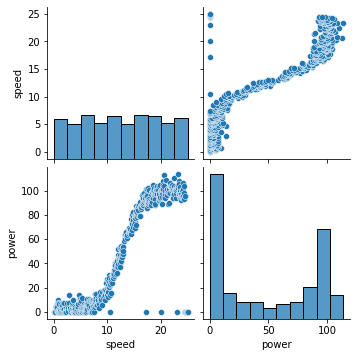

In [66]:
sns.pairplot(df);

From theese graphs we can see that there are several  0 values along the graphs. This could be due to a malfunction or maintenance period on the turbine itself so these will need to be removed before moving forward to determine an accurate algorithm. 

## Sources

https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/#:~:text=In%20order%20to%20check%20missing,null%20values%20in%20a%20series.